In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [9]:
from voxel_diffusion import VoxelConfig, create_model_and_trainer, create_dataloaders

config = VoxelConfig(
    use_rgb=False,  # or False for occupancy only
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

print(config.in_channels)

1


In [10]:
# Create model with the given config
trainer, model = create_model_and_trainer(
    config=config,
    resolution=32,
    device=device
)

Total parameters: 120096449


In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=config,
    batch_size=1
)

Finding voxel files: 44it [00:00, 51956.47it/s]


Found 44 files (including augmentations)


In [12]:
# Train model
losses, test_losses = trainer.train(
    train_loader,
    test_loader,
    total_steps=100_000,
    save_every=20_000,
    eval_every=20_000,
    save_dir='runs/experiment_1'
)

Training:   0%|          | 0/100000 [00:00<?, ?it/s]/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: Fu

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
steps = list(range(0, len(test_losses) * 20_000, 20_000))
plt.plot(steps, test_losses)
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Sampling Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


(2, 1, 32, 32, 32)


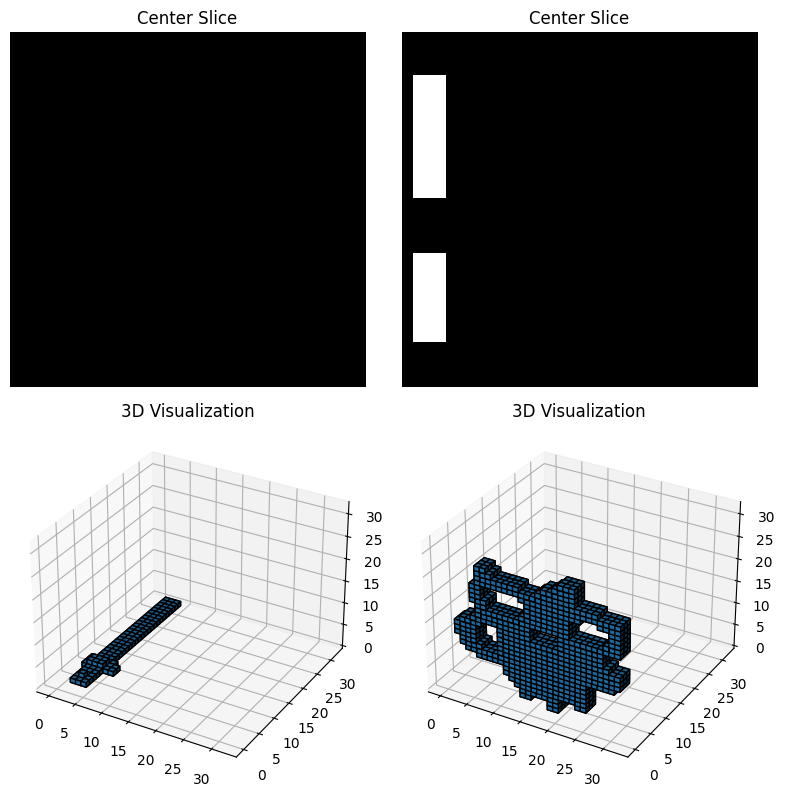

In [6]:
from inference import DiffusionInference3D
from diffusers import DDIMScheduler


diffusion_model = DiffusionModel3D(model, num_timesteps=1000)

diffusion_model.load_state_dict(torch.load("./best_model.pth"))

diffusion_model.to(device)

# noise_scheduler = DDIMScheduler.from_config(diffusion_model.noise_scheduler.config, timestep_spacing="trailing")

# inference = DiffusionInference3D(diffusion_model, noise_scheduler, device=device)
# samples = inference.sample_ddim(num_samples=2, image_size=(32, 32, 32), num_inference_steps = 200, intermediate_visualisation=True)


inference = DiffusionInference3D(diffusion_model, diffusion_model.noise_scheduler, device=device)
samples = inference.sample(num_samples=2, image_size=(32, 32, 32), show_intermediate=False)

inference.visualize_samples(samples, threshold=0.5)
